<a href="https://www.kaggle.com/code/eugenetomashy/classic-deep-models-vs-transformers?scriptVersionId=230380557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install ucimlrepo

# Description
The dataset provides patient reviews on specific drugs along with related conditions. Reviews and ratings are grouped into reports on the three aspects benefits, side effects and overall comment.


1. urlDrugName (categorical): name of drug
2. condition (categorical): name of condition
3. benefitsReview (text): patient on benefits
4. sideEffectsReview (text): patient on side effects
5. commentsReview (text): overall patient comment
6. rating (numerical): 10 star patient rating
7. sideEffects (categorical): 5 step side effect rating
8. effectiveness (categorical): 5 step effectiveness rating

# Load data

In [ ]:
from ucimlrepo import fetch_ucirepo
drug_reviews_druglib_com = fetch_ucirepo(id=461)
X = drug_reviews_druglib_com.data.features
df = X.copy()

In [ ]:
df.head(3).T

,0,1,2
urlDrugName,enalapril,ortho-tri-cyclen,ponstel
rating,4,1,10
effectiveness,Highly Effective,Highly Effective,Highly Effective
sideEffects,Mild Side Effects,Severe Side Effects,No Side Effects
condition,management of congestive heart failure,birth prevention,menstrual cramps
benefitsReview,slowed the progression of left ventricular dys...,Although this type of birth control has more c...,I was used to having cramps so badly that they...
sideEffectsReview,"cough, hypotension , proteinuria, impotence , ...","Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...",Heavier bleeding and clotting than normal.
commentsReview,"monitor blood pressure , weight and asses for ...","I Hate This Birth Control, I Would Not Suggest...",I took 2 pills at the onset of my menstrual cr...


# Datasets

In [ ]:
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
from sklearn.model_selection import train_test_split
import torchtext

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


class DrugReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class DrugReviewTransformersDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        print("Length of texts:", len(texts))
        print("Length of labels:", len(labels))
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Models

### Classic models

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.nn.functional import softmax


class TwoLayerGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerGRU, self).__init__()

        self.gru = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tensor(x).float()
        # x = x.float()
        out, _ = self.gru(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tensor(x).float()
        out, _ = self.lstm(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

class TwoLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tensor(x).float()
        out, _ = self.rnn(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

### Transformers

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        for param in self.bert.parameters():
          param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

class GPT2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(GPT2Classifier, self).__init__()
        self.gpt2 = GPT2Model.from_pretrained('gpt2')

        for param in self.gpt2.parameters():
          param.requires_grad = False

        self.fc = nn.Linear(self.gpt2.config.n_embd, num_classes)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.fc(pooled_output)
        return logits

class TransformerTrainer:
    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer, device='cpu'):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.history = {"validation": {"loss": [], "metrics": {}},
                        "train": {"loss": [], "metrics": {}}}

    def train(self, num_epochs):
        self.model.to(self.device)
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            probs_ls = []
            preds_ls = []
            labels_ls = []
            for batch in self.train_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                labels = batch['label'].to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(input_ids, attention_mask, token_type_ids)

                probs = softmax(outputs.detach().cpu(), dim=1).cpu().numpy()
                pred = outputs.argmax(dim=1).cpu().numpy()
                probs_ls.extend(probs)
                preds_ls.extend(pred)
                labels_ls.extend(labels.cpu().numpy())

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            train_loss = running_loss / len(self.train_dataloader)

            evaluate_model(labels_ls, preds_ls, probs_ls, self.history["train"]["metrics"])
            self.history["train"]["loss"].append(train_loss)
            val_loss, val_acc = self.evaluate()

            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        return self.history

    def evaluate(self):
        self.model.eval()
        val_loss = 0.0
        probs_ls = []
        preds_ls = []
        labels_ls = []

        with torch.no_grad():
            for batch in self.val_dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                token_type_ids = batch['token_type_ids'].to(self.device)
                batch_labels = batch['label'].to(self.device)

                outputs = self.model(input_ids, attention_mask, token_type_ids)

                probs = softmax(outputs.detach().cpu(), dim=1).cpu().numpy()
                pred = outputs.argmax(dim=1).cpu().numpy()

                loss = self.criterion(outputs, batch_labels)
                val_loss += loss.item()

                preds_ls.extend(pred)
                probs_ls.extend(probs)
                labels_ls.extend(batch_labels.cpu().numpy())

        val_loss /= len(self.val_dataloader)

        val_acc = accuracy_score(labels_ls, preds_ls) * 100
        evaluate_model(labels_ls, preds_ls, probs_ls, self.history["validation"]["metrics"])
        self.history["validation"]["loss"].append(val_loss)

        return val_loss, val_acc

# Logic for training

# Load data train model

In [ ]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
cols = ["urlDrugName", "condition", "effectiveness", "sideEffects",  "sideEffectsReview", "commentsReview", "benefitsReview"]
df["review"] = df.apply(lambda r: preprocess_text(" ".join([str(r[col]) for col in cols])), axis=1)

max_words = 10000
max_sequence_length = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["review"].str.lower())

Metrics:
- accuracy
- balanced_accuracy
- f1
- roc_auc
- precision
- recall
- confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, roc_auc_score, confusion_matrix
# from scipy.special import softmax


def evaluate_model(y, x, probs, d_scores={}, metrics=None):
  if metrics is None:
    metrics = dict(accuracy=accuracy_score, balanced_accuracy=balanced_accuracy_score,
                          classification_report=classification_report,
                          confusion_matrix=confusion_matrix, roc_auc=lambda y, x: roc_auc_score(y, probs, multi_class='ovr') )

  for k, score_func in metrics.items():
    d_scores[k] = d_scores.get(k, []) + [score_func(y, x)]


def simple_train(model, optimizer, criterion, X_train, X_val, y_train, y_val, train_loader, val_loader, num_epochs = 10):
  # d_scores = {}
  history = {"train": {"loss": [], "metrics": {}}, "validation": {"loss": [], "metrics": {}}}

  for epoch in range(num_epochs):
      train_loss = 0
      for inputs, targets in train_loader:
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, targets.long())
          train_loss += loss.item()
          loss.backward()
          optimizer.step()

      train_loss /= len(train_loader)
      history["train"]["loss"].append(train_loss)


      model.eval()
      with torch.no_grad():
          val_loss = 0
          for inputs, targets in val_loader:
              outputs = model(inputs)
              val_loss += criterion(outputs, targets.long()).item()

          val_loss /= len(val_loader)
          history["validation"]["loss"].append(val_loss)

      outputs = model(X_train)
      train_probs = softmax(outputs.detach().cpu(), dim=1).cpu().numpy()
      train_pred = outputs.argmax(dim=1).cpu().numpy()

      outputs = model(X_val)
      test_probs = softmax(outputs.detach().cpu(), dim=1).cpu().numpy()
      test_pred = outputs.argmax(dim=1).cpu().numpy()

      evaluate_model(y_train, train_pred, train_probs, history["train"]["metrics"])
      evaluate_model(y_val, test_pred, test_probs, history["validation"]["metrics"])


      print(f"epoch {epoch}...")
  return history

# Framework for training / evaluating

In [ ]:
import pickle
import os

def save_to_pickle(obj, filename="rating.pkl"):
  folder_path = "/content/drive/MyDrive/3 year/Neural networks"
  filepath = os.path.join(folder_path, filename)
  with open(filename, "wb") as fileholder:
    pickle.dump(obj, fileholder)

def load_pickle(filename="rating.pkl"):
  folder_path = "/content/drive/MyDrive/3 year/Neural networks"
  filepath = os.path.join(folder_path, filename)
  obj = None
  with open(filename, "rb") as fileholder:
    obj = pickle.load(fileholder)

  return obj

In [ ]:
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


class ModelEvaluator:
    hidden_size = 128

    def __init__(self, x, y, num_epochs=10):
        self.models = {
            'rnn': TwoLayerRNN,
            'gru': TwoLayerGRU,
            'lstm': TwoLayerLSTM,
            # 'gpt': GPTModel(),
            # 'bert': BERTModel()
        }
        self.target_col = y.name.split("_")[0]
        self.results = {}
        self.train_loader, self.val_loader = self.get_train_validation_loader(x, y)
        self.num_epochs = num_epochs

    def get_train_validation_loader(self, x, y, max_sequence_length=20):
      self.max_sequence_length = max_sequence_length
      sequences = tokenizer.texts_to_sequences(x)
      sequences = pad_sequences(sequences, maxlen=max_sequence_length)
      X_train, X_val, y_train, y_val = train_test_split(sequences.astype(float), y.to_numpy(), test_size=0.2, random_state=42)
      self.X_train, self.X_val = X_train, X_val
      self.input_size = X_train.shape[-1]
      self.output_size = len(np.unique(y_train))

      self.y_train, self.y_val = y_train, y_val

      train_dataset = DrugReviewDataset(X_train, y_train)
      val_dataset = DrugReviewDataset(X_val, y_val)

      train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=32)

      return train_loader, val_loader

    def train_models(self):
        criterion = nn.CrossEntropyLoss()

        for model_name, model_class in self.models.items():
          print(f"Training {model_name}...")
          model = model_class(self.input_size, self.hidden_size, self.output_size)
          optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
          self.results[model_name] = simple_train(model, optimizer, criterion, self.X_train, self.X_val, self.y_train, self.y_val,
                                                  self.train_loader, self.val_loader, num_epochs=self.num_epochs)
        try:
          self.save_results()
          print("results were successfully saved")
        except Exception as e:
          print("results are not saved")
          raise e

    def plot_losses(self):
      for i, model in enumerate(self.results.keys()):
        ax = plt.subplot(len(self.results), 1, i + 1)
        ax.plot(list(range(1, self.num_epochs + 1)), self.results[model]["train"]["loss"], color="blue", label="train")
        ax.plot(list(range(1, self.num_epochs + 1)), self.results[model]["validation"]["loss"], color="red", label="test")
        ax.grid(which="both")
        ax.set_title(model.upper())

      plt.legend()
      plt.tight_layout()
      plt.show()

    def visualize_metrics(self):
      fig = plt.figure(figsize=(10, 8))
      ax = plt.gca()
      for i, model in enumerate(self.results.keys()):
        ax = plt.subplot(len(self.results), 1, i+1)
        for metric in ["accuracy", "balanced_accuracy", "roc_auc"]:
          ax.plot(self.results[model]["validation"]["metrics"][metric], label=metric)
          ax.grid(which="both")
          ax.set_title(model.upper())
          ax.legend()

        print(f"{'x'*10} {model.upper()} {'x'*10}")
        for metric in ["classification_report", "confusion_matrix"]:
          print(metric)
          print(self.results[model]["validation"]["metrics"][metric][-1], end="\n\n")

      fig.tight_layout()
      fig.show()

    def save_results(self):
      save_to_pickle(self.results, f"{self.target_col}.pkl")

    def load_results(self):
      self.results = load_pickle(f"{self.target_col}.pkl")

# Train/evaluate

In [ ]:
def convert_rating_into_classes(r):
  if r["rating"] <= 4:
    return 0
  elif 4 < r["rating"] < 7:
    return 1
  else:
    return 2

def convert_effectiveness_into_classes(r):
  if r["effectiveness"] in ["Marginally Effective", "Moderately Effective"]:
    return 1
  elif r["effectiveness"] in ["Highly Effective", "Considerably Effective"]:
    return 2
  else:
    return 0

def convert_side_effects_into_classes(r):
  col = "sideEffects"
  if r[col] in ["No Side Effects"]:
    return 0
  if r[col] in ["Mild Side Effects", "Moderate Side Effects"]:
    return 1
  else:
    return 2

In [ ]:
# df["sideEffects"].value_counts()
# df["effectiveness"].apply

In [ ]:
from sklearn.preprocessing import LabelEncoder
df["effectiveness_prep"] = df.apply(convert_effectiveness_into_classes, axis=1)
df["sideEffects_prep"] = df.apply(convert_side_effects_into_classes, axis=1)

# adjusting classes (make 3 categories)
df["rating_prep"] = df.apply(convert_rating_into_classes, axis=1)


In [ ]:
NUM_EPOCHS = 10
histories_by_task = {}

## Bert training

### Target rating

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_texts, val_texts, train_labels, val_labels = train_test_split(df["review"].values, df["rating_prep"].values, test_size=0.2)
train_dataset = DrugReviewTransformersDataset(train_texts, train_labels, bert_tokenizer, max_len=128)
val_dataset = DrugReviewTransformersDataset(val_texts, val_labels, bert_tokenizer, max_len=128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
bert_model = BERTClassifier(df["rating_prep"].nunique())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)

bert_trainer = TransformerTrainer(bert_model, train_dataloader, val_dataloader, criterion, optimizer)
bert_trainer.train(num_epochs=3)
save_to_pickle(bert_trainer.history, "bert_rating.pkl")

Epoch 1/3, Train Loss: 0.9742, Val Loss: 0.8831, Val Acc: 66.71%
Epoch 2/3, Train Loss: 0.8564, Val Loss: 0.8534, Val Acc: 66.71%
Epoch 3/3, Train Loss: 0.8403, Val Loss: 0.8521, Val Acc: 66.71%


xxxxxxxxxx BERT xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.00      0.00      0.00        96
           2       0.67      1.00      0.80       553

    accuracy                           0.67       829
   macro avg       0.22      0.33      0.27       829
weighted avg       0.44      0.67      0.53       829


confusion_matrix
[[  0   0 180]
 [  0   0  96]
 [  0   0 553]]



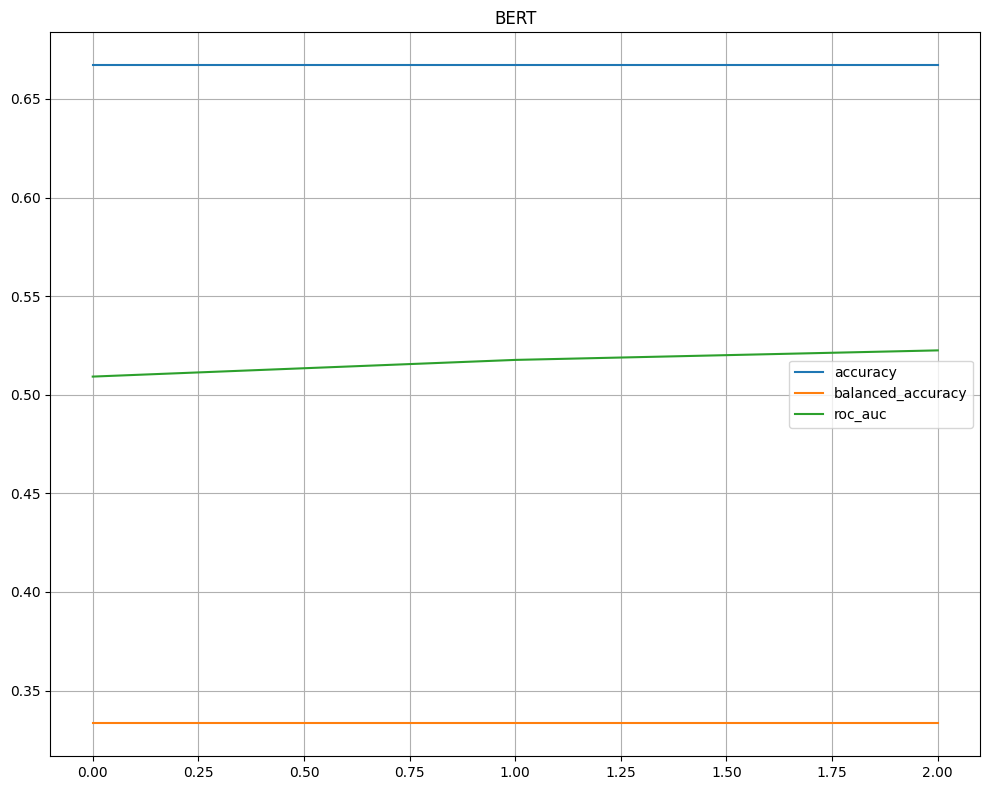

In [ ]:
model_eval = ModelEvaluator(df["review"], df["rating_prep"], num_epochs=3)
model_eval.models = {"bert": None}
model_eval.results = {"bert": load_pickle("bert_rating.pkl")}
model_eval.visualize_metrics()

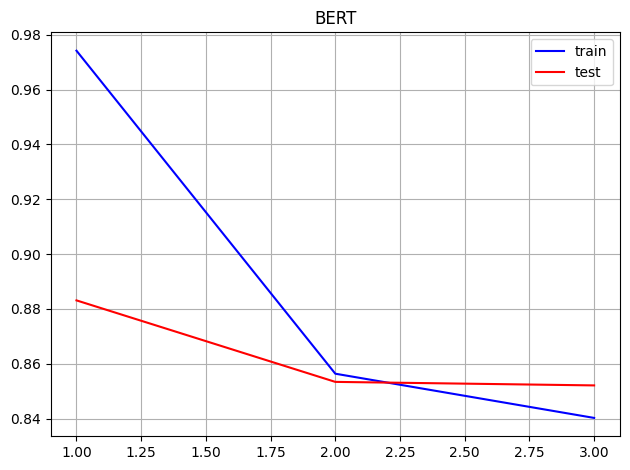

In [ ]:
model_eval.plot_losses()

## Target effectiveness

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_texts, val_texts, train_labels, val_labels = train_test_split(df["review"].values, df["effectiveness_prep"].values, test_size=0.2)
train_dataset = DrugReviewTransformersDataset(train_texts, train_labels, bert_tokenizer, max_len=128)
val_dataset = DrugReviewTransformersDataset(val_texts, val_labels, bert_tokenizer, max_len=128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

Length of texts: 3314
Length of labels: 3314
Length of texts: 829
Length of labels: 829


In [ ]:
bert_model = BERTClassifier(df["effectiveness_prep"].nunique())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)

bert_trainer = TransformerTrainer(bert_model, train_dataloader, val_dataloader, criterion, optimizer)
bert_trainer.train(num_epochs=3)
save_to_pickle(bert_trainer.history, "bert_effectiveness.pkl")

Epoch 1/3, Train Loss: 0.9523, Val Loss: 0.8130, Val Acc: 72.14%
Epoch 2/3, Train Loss: 0.7956, Val Loss: 0.7649, Val Acc: 72.14%
Epoch 3/3, Train Loss: 0.7729, Val Loss: 0.7581, Val Acc: 72.14%


xxxxxxxxxx BERT xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       171
           2       0.72      1.00      0.84       598

    accuracy                           0.72       829
   macro avg       0.24      0.33      0.28       829
weighted avg       0.52      0.72      0.60       829


confusion_matrix
[[  0   0  60]
 [  0   0 171]
 [  0   0 598]]



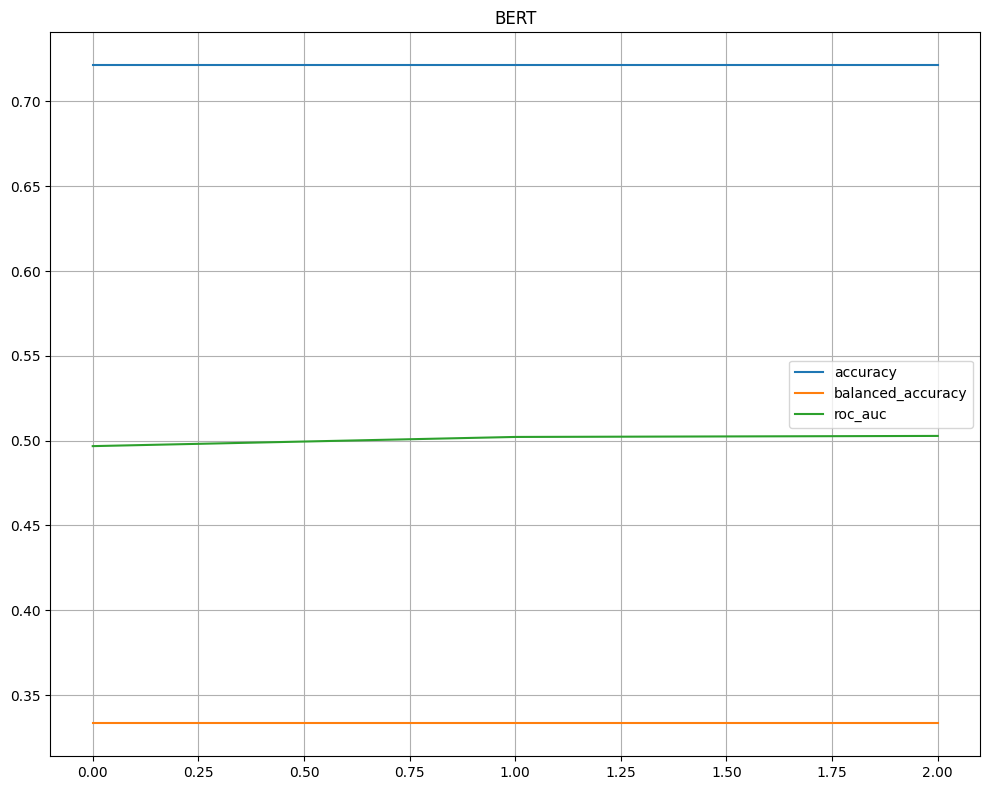

In [ ]:
model_eval = ModelEvaluator(df["review"], df["effectiveness_prep"], num_epochs=3)
model_eval.models = {"bert": None}
model_eval.results = {"bert": load_pickle("bert_effectiveness.pkl")}
model_eval.visualize_metrics()

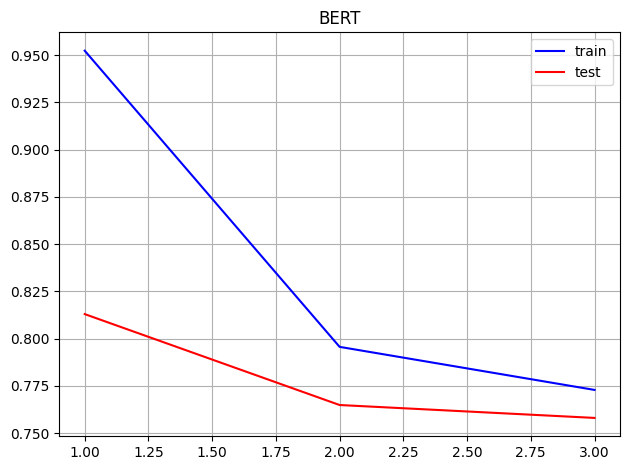

In [ ]:
model_eval.plot_losses()


### Target SideEffects

In [ ]:
bert_model = BERTClassifier(df["sideEffects_prep"].nunique())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)

bert_trainer = TransformerTrainer(bert_model, train_dataloader, val_dataloader, criterion, optimizer)
bert_trainer.train(num_epochs=3)
save_to_pickle(bert_trainer.history, "bert_sideEffects.pkl")

Epoch 1/3, Train Loss: 1.2344, Val Loss: 0.9877, Val Acc: 69.48%
Epoch 2/3, Train Loss: 0.9128, Val Loss: 0.8146, Val Acc: 72.14%
Epoch 3/3, Train Loss: 0.8163, Val Loss: 0.7728, Val Acc: 72.14%


xxxxxxxxxx BERT xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       171
           2       0.72      1.00      0.84       598

    accuracy                           0.72       829
   macro avg       0.24      0.33      0.28       829
weighted avg       0.52      0.72      0.60       829


confusion_matrix
[[  0   0  60]
 [  0   0 171]
 [  0   0 598]]



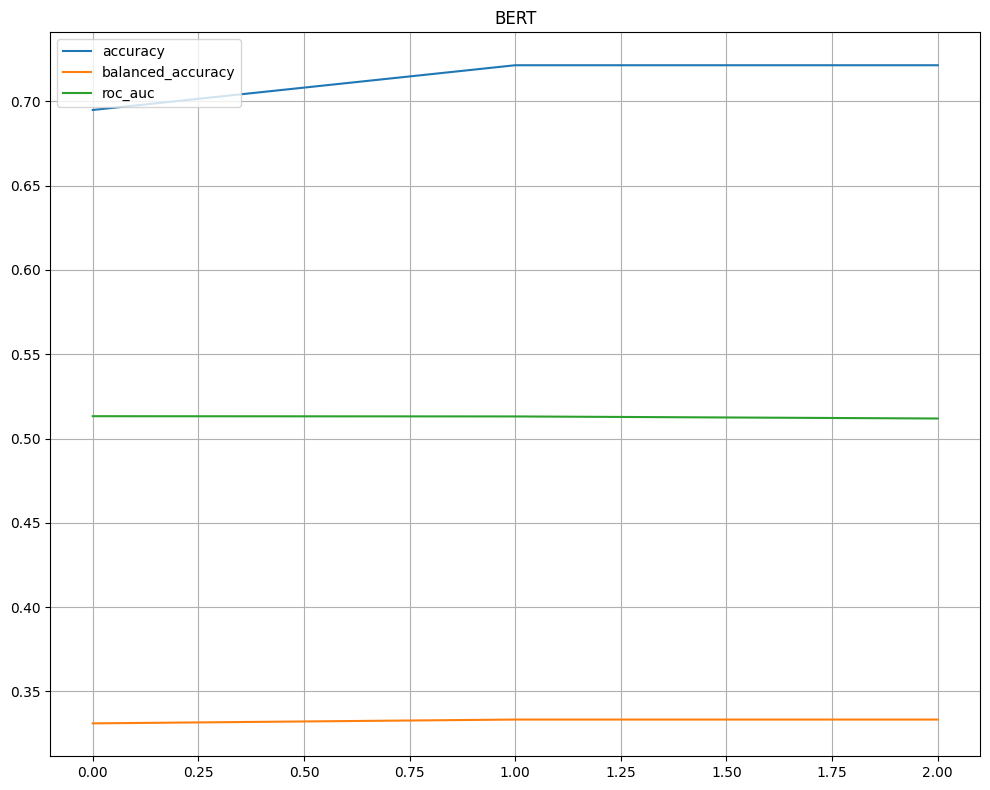

In [ ]:
model_eval = ModelEvaluator(df["review"], df["sideEffects_prep"], num_epochs=3)
model_eval.models = {"bert": None}
model_eval.results = {"bert": load_pickle("bert_sideEffects.pkl")}
model_eval.visualize_metrics()

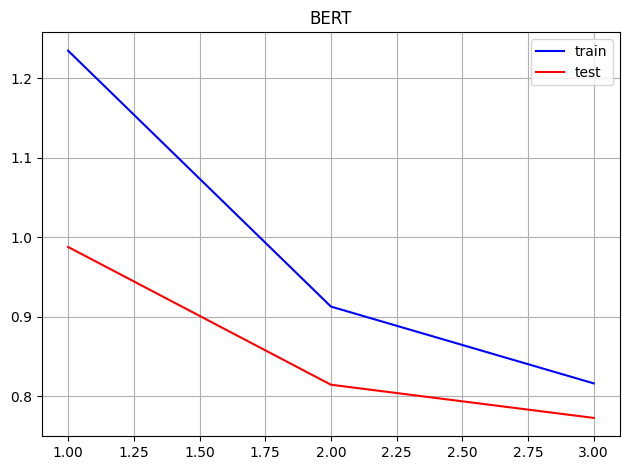

In [ ]:
model_eval.plot_losses()

## Gpt training
- Wrote logic, but didn't have time to train

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_texts, val_texts, train_labels, val_labels = train_test_split(df["review"].values, df["rating_prep"].values, test_size=0.2)
train_dataset = DrugReviewTransformersDataset(train_texts, train_labels, bert_tokenizer, max_len=128)
val_dataset = DrugReviewTransformersDataset(val_texts, val_labels, bert_tokenizer, max_len=128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

gpt_model = GPT2Classifier(df["effectiveness_prep"].nunique())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpt_model.parameters(), lr=2e-5)

gpt_trainer = TransformerTrainer(gpt_model, train_dataloader, val_dataloader, criterion, optimizer)
gpt_trainer.train(num_epochs=1)
save_to_pickle(gpt_trainer.history, "gpt_rating.pkl")

## target rating

In [ ]:
evaluator = ModelEvaluator(df["review"], df["rating_prep"], num_epochs=NUM_EPOCHS)
evaluator.train_models()
# evaluator.load_results()

xxxxxxxxxx RNN xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.00      0.00      0.00        90
           2       0.68      1.00      0.81       562

    accuracy                           0.68       829
   macro avg       0.23      0.33      0.27       829
weighted avg       0.46      0.68      0.55       829


confusion_matrix
[[  0   0 177]
 [  0   0  90]
 [  1   0 561]]

xxxxxxxxxx GRU xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       177
           1       0.00      0.00      0.00        90
           2       0.68      1.00      0.81       562

    accuracy                           0.68       829
   macro avg       0.23      0.33      0.27       829
weighted avg       0.46      0.68      0.55       829


confusion_matrix
[[  0   0 177]
 [  0   0  90]
 [  0   0 562]]

xxxxxxxxxx L

<ipython-input-23-b2ef5831d6a5>:74: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(self.results), 1, i+1)


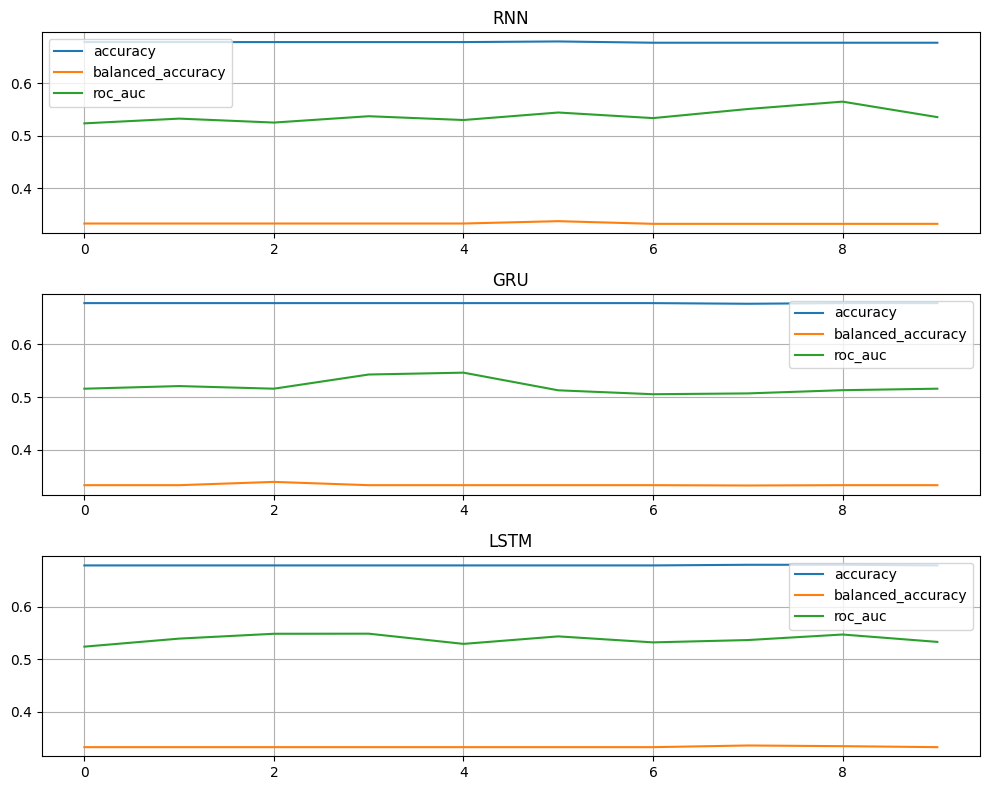

In [ ]:
evaluator.visualize_metrics()

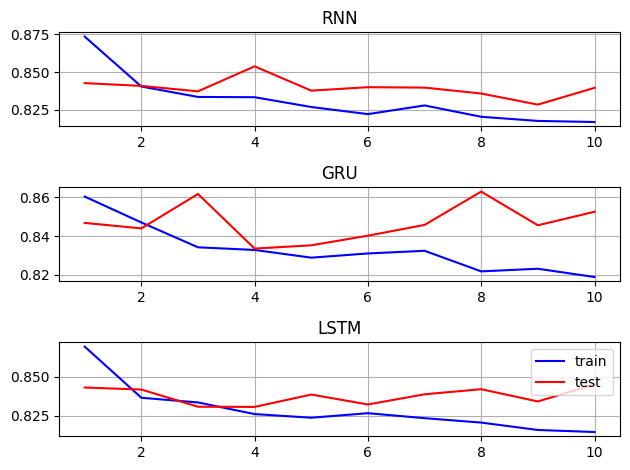

In [ ]:
evaluator.plot_losses()

In [ ]:
histories_by_task["rating"] = evaluator.results

## Target effectiveness/Benefits

In [ ]:
evaluator = ModelEvaluator(df["review"], df["effectiveness_prep"], num_epochs=NUM_EPOCHS)
evaluator.train_models()

Training rnn...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
Training gru...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
Training lstm...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
results were successfully saved


xxxxxxxxxx RNN xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       170
           2       0.72      1.00      0.84       595

    accuracy                           0.72       829
   macro avg       0.24      0.33      0.28       829
weighted avg       0.52      0.72      0.60       829


confusion_matrix
[[  0   0  64]
 [  0   0 170]
 [  0   0 595]]

xxxxxxxxxx GRU xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        64
           1       0.00      0.00      0.00       170
           2       0.72      1.00      0.84       595

    accuracy                           0.72       829
   macro avg       0.24      0.33      0.28       829
weighted avg       0.52      0.72      0.60       829


confusion_matrix
[[  0   0  64]
 [  0   0 170]
 [  0   0 595]]

xxxxxxxxxx L

<ipython-input-23-b2ef5831d6a5>:74: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(self.results), 1, i+1)


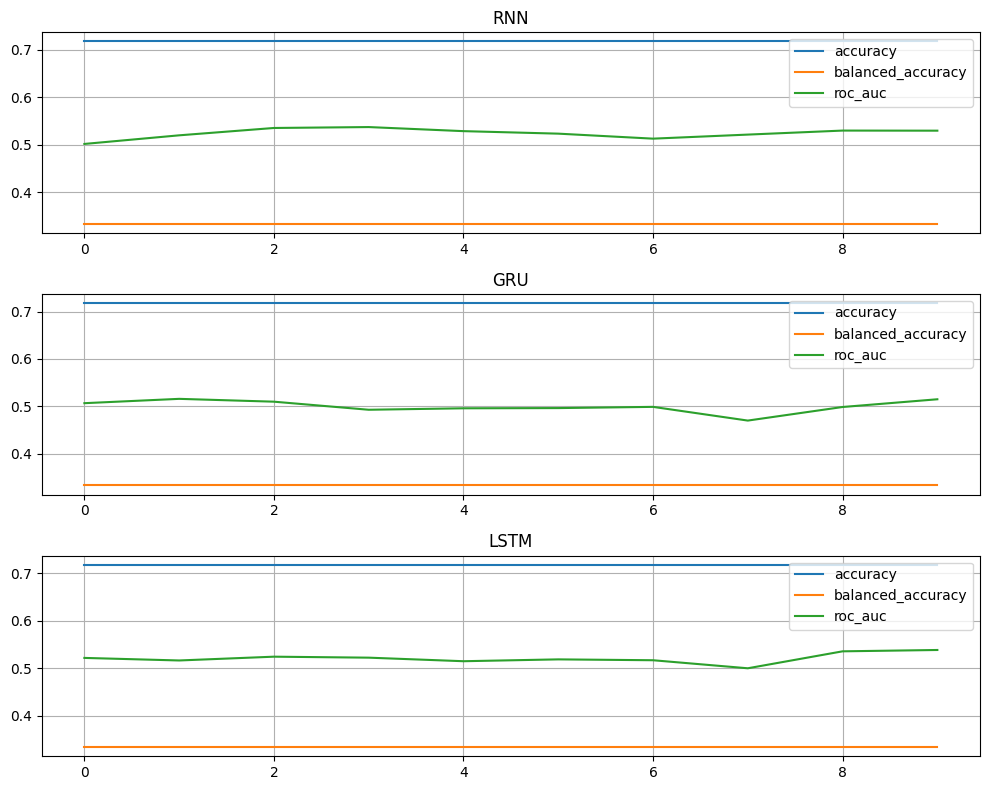

In [ ]:
evaluator.visualize_metrics()

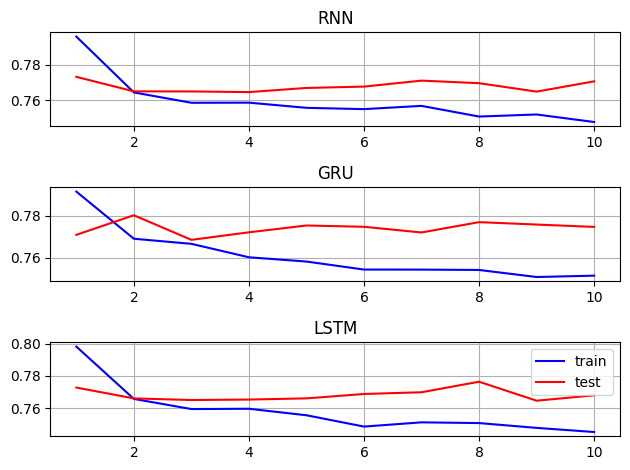

In [ ]:
evaluator.plot_losses()

In [ ]:
histories_by_task["effectiveness"] = evaluator.results

## Target side effects

In [ ]:
evaluator = ModelEvaluator(df["review"], df["sideEffects_prep"], num_epochs=NUM_EPOCHS)
evaluator.train_models()

Training rnn...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
Training gru...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
Training lstm...
epoch 0...
epoch 1...
epoch 2...
epoch 3...
epoch 4...
epoch 5...
epoch 6...
epoch 7...
epoch 8...
epoch 9...
results were successfully saved


<ipython-input-23-b2ef5831d6a5>:74: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(len(self.results), 1, i+1)


xxxxxxxxxx RNN xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.21      0.03      0.06       245
           1       0.52      0.94      0.67       430
           2       0.10      0.01      0.01       154

    accuracy                           0.50       829
   macro avg       0.28      0.33      0.25       829
weighted avg       0.35      0.50      0.37       829


confusion_matrix
[[  8 234   3]
 [ 18 406   6]
 [ 12 141   1]]

xxxxxxxxxx GRU xxxxxxxxxx
classification_report
              precision    recall  f1-score   support

           0       0.11      0.01      0.02       245
           1       0.51      0.97      0.67       430
           2       0.00      0.00      0.00       154

    accuracy                           0.50       829
   macro avg       0.21      0.33      0.23       829
weighted avg       0.30      0.50      0.35       829


confusion_matrix
[[  2 243   0]
 [ 14 416   0]
 [  3 151   0]]

xxxxxxxxxx L

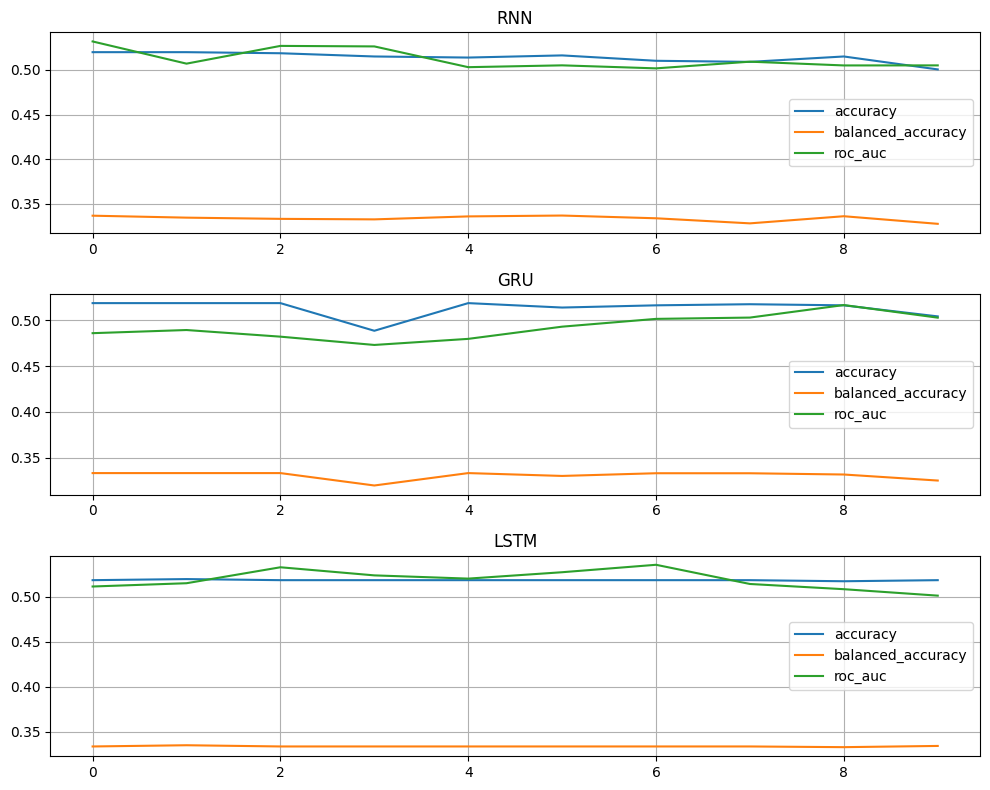

In [ ]:
evaluator.visualize_metrics()

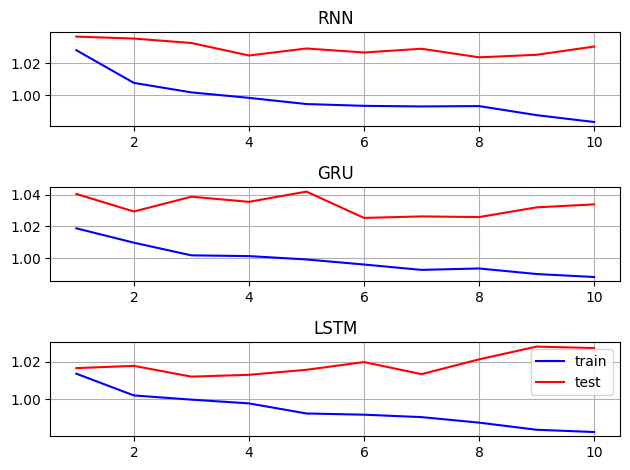

In [ ]:
evaluator.plot_losses()

In [ ]:
histories_by_task["sideEffects"] = evaluator.results

# Results
- Here I present accuracy of models to show that my results.

In [ ]:
import pandas as pd

In [ ]:
for dataset in ["rating", "effectiveness", "sideEffects"]:
  for model in ["rnn", "gru", "lstm"]:
    print(f"model: {model.upper()}\ndataset: {dataset}")
    acc_train = np.array(histories_by_task[dataset][model]["train"]["metrics"]["accuracy"])[-1]
    print(f"accuracy of the model on training set: {acc_train:.2f}")
    acc_val = np.array(histories_by_task[dataset][model]["validation"]["metrics"]["accuracy"])[-1]
    print(f"accuracy of the model on validation set: {acc_val:.2f}", end="\n"*2)
  print()

model: RNN
dataset: rating
accuracy of the model on training set: 0.68
accuracy of the model on validation set: 0.68

model: GRU
dataset: rating
accuracy of the model on training set: 0.67
accuracy of the model on validation set: 0.68

model: LSTM
dataset: rating
accuracy of the model on training set: 0.68
accuracy of the model on validation set: 0.68


model: RNN
dataset: effectiveness
accuracy of the model on training set: 0.72
accuracy of the model on validation set: 0.72

model: GRU
dataset: effectiveness
accuracy of the model on training set: 0.72
accuracy of the model on validation set: 0.72

model: LSTM
dataset: effectiveness
accuracy of the model on training set: 0.72
accuracy of the model on validation set: 0.72


model: RNN
dataset: sideEffects
accuracy of the model on training set: 0.54
accuracy of the model on validation set: 0.50

model: GRU
dataset: sideEffects
accuracy of the model on training set: 0.53
accuracy of the model on validation set: 0.50

model: LSTM
dataset: 

In [ ]:

for dataset in ["rating", "effectiveness", "sideEffects"]:
    print(f"model: BERT\ndataset: {dataset}")
    history = load_pickle(f"bert_{dataset}.pkl")
    acc_train = np.array(history["train"]["metrics"]["accuracy"])[-1]
    print(f"accuracy of the model on training set: {acc_train:.2f}")
    acc_val = np.array(history["validation"]["metrics"]["accuracy"])[-1]
    print(f"accuracy of the model on validation set: {acc_val:.2f}", end="\n"*2)


model: BERT
dataset: rating
accuracy of the model on training set: 0.68
accuracy of the model on validation set: 0.67

model: BERT
dataset: effectiveness
accuracy of the model on training set: 0.72
accuracy of the model on validation set: 0.72

model: BERT
dataset: sideEffects
accuracy of the model on training set: 0.72
accuracy of the model on validation set: 0.72

